In [1]:
import random
import os
import os.path


import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

In [2]:
import common.env_lib
from common.env_utils import sorl_plot
from common.rl_lib import ReplayBuffer, OUNoise, ENoise, ValueNetwork, PolicyNetwork, ddpg_update, calc_values_of_states

In [3]:
# arguments
seed = 914
env_name = "cenpv2"
max_noise = 0.7
GAMMA = 0.997

In [4]:
# set seed
# seed = 914
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [6]:
experiment = "g"+str(GAMMA)+"-n"+str(max_noise)
# env_name = "csense"
env = eval("common.env_lib."+env_name+"()")

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_lr  = 1e-3
policy_lr = 1e-4

# GAMMA = 1-(1E-3)
SOFT_TAU=1e-2

batch_size  = 128
replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [7]:
value_net  = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)
target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
value_criterion = nn.MSELoss()

In [8]:
exp_train_log ={}

env_location = 'tokyo'
exp_train_log[env_location] = {}    


START_YEAR = 1995
NO_OF_YEARS = 10
timeslots_per_day = 24
REQ_TYPE = "random"
prediction_horizon = 10*timeslots_per_day
henergy_mean= 0.13904705134356052 # 10yr hmean for tokyo

env_tag = env_name + '_t' + str(timeslots_per_day) + '_' + REQ_TYPE
model_tag = experiment +'-'+str(seed)

exp_tag = env_tag  + "-" + experiment # key name in dictionary
tag = env_tag + "-" + model_tag # tensorboard tag and name of model filename
print("TensorBoard TAG: ",tag)
writer_folder = './runs/'+ env_name+"-"+experiment +"/" + tag
writer = SummaryWriter(log_dir=writer_folder)


episode = 0
frame_idx = 0
eval_states = None # will be populated with held-out states

# max_noise = 0.7

# evaluate Q-values of random states
NO_OF_STATES_TO_EVALUATE = timeslots_per_day*20 # how many states to sample to evaluate
EVAL_FREQ = prediction_horizon # how often to evaluate

TensorBoard TAG:  cenpv2_t24_random-g0.997-n0.7-914


Year:	 1995
Avg. Supply: 	 0.12686208471286678
Avg. Request: 	 0.13561662505656952
Avg reward:	 0.31402797255312676
Downtimes:	 3


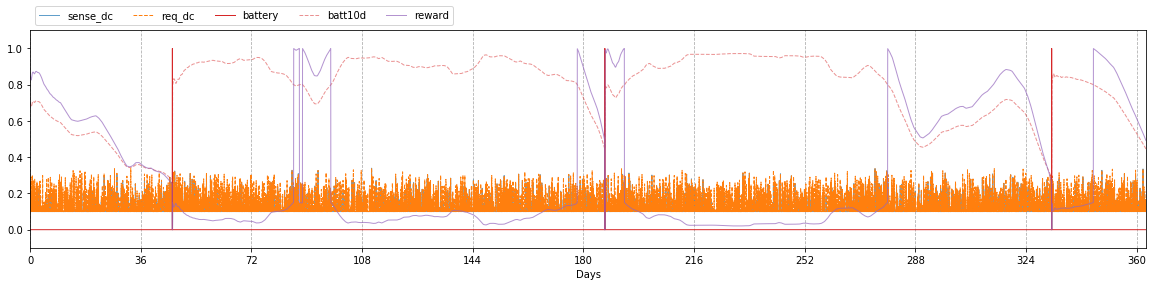

**********************************************************************



In [ ]:
for year in range(START_YEAR, START_YEAR+NO_OF_YEARS):
       
    exp_noise = ENoise(env.action_space, 
                       max_sigma=max_noise, 
                       min_sigma=0.01, 
                       decay_period=30*timeslots_per_day)
    
    env.set_env(env_location, year, timeslots_per_day, 
                REQ_TYPE, offset=timeslots_per_day/2,
                p_horizon=prediction_horizon,
                hmean=henergy_mean)
    state = env.reset()
    reward_rec = []
    ep_done_rec = []
    episode_reward = 0
    step = 0
    done = False
    counter = 0 # record of number of steps in the environment. Required to keep a finite episode length

    while not done:
        if env.RECOVERY_MODE:
            no_action = 0            
            next_state, reward, done, _ = env.step(no_action)
            writer.add_scalar("Action/0_raw_action", no_action, frame_idx)
            writer.add_scalar("Action/1_noisy_action", no_action, frame_idx)
            writer.add_scalar("Action/2_tr_action", no_action, frame_idx)
            writer.add_scalar("Reward/reward", reward, frame_idx)        
            reward_rec.append(reward)
            ep_done = done or env.RECOVERY_MODE
            ep_done_rec.append(ep_done)
            state = next_state
            frame_idx +=1
            counter = 0

        else:
            raw_action = policy_net.get_action(state)
            noisy_action = exp_noise.get_action(raw_action, t=0)
            tr_action = (noisy_action*0.5 + 0.5)
            next_state, reward, done, _ = env.step(tr_action) 
            writer.add_scalar("Action/0_raw_action", raw_action, frame_idx)
            writer.add_scalar("Action/1_noisy_action", noisy_action, frame_idx)
            writer.add_scalar("Action/2_tr_action", tr_action, frame_idx)
            writer.add_scalar("Reward/reward", reward, frame_idx)        
            reward_rec.append(reward)
            ep_done = done or env.RECOVERY_MODE or (counter==prediction_horizon-1)
            ep_done_rec.append(ep_done)
        
            replay_buffer.push(state, noisy_action, reward, next_state, ep_done)
            if len(replay_buffer) > batch_size:
                ddpg_update(value_net,
                            target_value_net,
                            policy_net,
                            target_policy_net,
                            value_optimizer,
                            policy_optimizer,
                            value_criterion,
                            batch_size,
                            replay_buffer,
                            device,
                            writer,
                            frame_idx,
                            gamma=GAMMA,
                            min_value=-np.inf,
                            max_value=np.inf,
                            soft_tau=1e-2,
                            policy_clipgrad=0.5,
                            value_clipgrad=0.5)
            episode_reward += reward
            step += 1 # to decrease exploration noise
            frame_idx +=1
            counter +=1
            state = next_state
            
            if ep_done:
                writer.add_scalar("Reward/episode_reward", episode_reward, episode)
                episode_reward = 0 # reset episode reward
                episode +=1 # increase episode count
                counter = 0 # reset episode counter
                # as episode count grows, start with lesser exploration noise
                step = episode 
            if env.RECOVERY_MODE:
                # start with increased exploration noise if recovery mode
                step -= timeslots_per_day
                step = max(0,step)
        
        if len(replay_buffer) > 3*NO_OF_STATES_TO_EVALUATE and eval_states is None:
            eval_states, eval_actions, _ ,_ , _ = replay_buffer.sample(NO_OF_STATES_TO_EVALUATE)
            eval_states = torch.FloatTensor(eval_states).to(device)
            eval_actions = torch.FloatTensor(eval_actions).unsqueeze(1).to(device)

        if eval_states is not None and frame_idx % EVAL_FREQ == 0:
            mean_val = calc_values_of_states(eval_states, eval_actions, value_net, device=device)
            writer.add_scalar("values_mean", mean_val, frame_idx)
                
     # Log the traces and summarize results
    iteration_result={}

    # Saving traces
    iteration_result['reward_rec'] = np.array(reward_rec)
    iteration_result['ep_done_rec'] = np.array(ep_done_rec)
    iteration_result['action_log'] = np.array(env.action_log)
    iteration_result['sense_dc_log'] = np.array(env.sense_dc_log)
    iteration_result['env_log'] = np.array(env.env_log)
    iteration_result['eno_log'] = np.array(env.eno_log)
    iteration_result['sense_reward_log'] = np.array(env.sense_reward_log)
    iteration_result['enp_reward_log'] = np.array(env.enp_reward_log)

    
    # Summarizing results
    env_log = iteration_result['env_log']

    # Get henergy metrics
    henergy_rec = env_log[:,1]
    avg_henergy = henergy_rec.mean()
    iteration_result['avg_henergy'] = avg_henergy

    # Get req metrics
    req_rec = env_log[:,5]
    avg_req = req_rec.mean()            
    iteration_result['avg_req'] = avg_req

    # Get reward metrics
    # In this case, the reward metrics directly reflect the conformity
    reward_recx = iteration_result['reward_rec']
    # negative rewards = -1000 correspond to downtimes
    # To find average reward, remove negative values
    index = np.argwhere(reward_recx<0)
    rwd_recx = np.delete(reward_recx, index)
    avg_rwd = rwd_recx.mean()
    iteration_result['avg_rwd'] = avg_rwd

    # Get downtime metrics
#     ep_done_rec =  iteration_result['ep_done_rec']
#     downtimes = np.count_nonzero(ep_done_rec[:-1] < ep_done_rec[1:]) - 1 # last env done is excluded
    batt_rec = env_log[:,3]
    batt_rec[batt_rec>0.1]=0
    batt_rec[batt_rec!=0]=1
    downtimes = np.count_nonzero(batt_rec[:-1] < batt_rec[1:])
    iteration_result['downtimes'] = downtimes

    # Get ENP metrics
    eno_log = iteration_result['eno_log']
    enp_log = []
    enp_log.append(eno_log[0])
    for t in range(1,len(eno_log)):
        enp = enp_log[-1] + eno_log[t]
        enp = np.clip(enp,0,1)
        enp_log.append(enp)
    iteration_result['enp_log'] = np.array(enp_log)
    
    # Print summary
    print("Year:\t", year)            
    print("Avg. Supply: \t", avg_henergy)
    print("Avg. Request: \t", avg_req)
    print("Avg reward:\t", avg_rwd)
    print("Downtimes:\t", downtimes)
    
    # Plot traces
    sorl_plot(iteration_result, timeslots_per_day, START_DAY=0, NO_OF_DAY_TO_PLOT = 363)
    
    # Store results, traces and summary
    exp_train_log[env_location][year] = iteration_result
    print("*"*70)
    print("")

In [ ]:
if os.path.exists('./results/all_train_results.npy'):
    train_results = np.load('./results/all_train_results.npy',allow_pickle='TRUE').item()
else:
    train_results = {}

if exp_tag not in train_results:
    train_results[exp_tag] = {}
train_results[exp_tag][seed] = exp_train_log
np.save('./results/all_train_results.npy', train_results)

In [ ]:
# display training performance metrics
train_log = train_results[exp_tag][seed][env_location]

print("#".ljust(3), "HMEAN".ljust(8), "REQ_MEAN".ljust(8), "AVG_DC".ljust(8), 
      "SNS_RWD".ljust(8), "ENP_RWD".ljust(8), "AVG_RWD".ljust(8), "DOWNTIMES".ljust(9))
for year in list(train_log.keys()):
    iteration_result =  train_log[year]
    # Print summarized metrics
    print(year, end=' ')
    sense_avg_rwd = iteration_result['sense_reward_log'].mean()
    enp_avg_rwd = iteration_result['enp_reward_log'].mean()
    average_rwd = iteration_result['avg_rwd']
    total_downtimes = iteration_result['downtimes']
    hmean = iteration_result['avg_henergy']
    reqmean = iteration_result['avg_req']
    sense_dc_mean = iteration_result['sense_dc_log'].mean()
    
    print(f'{hmean:7.3f}',end='  ')
    print(f'{reqmean:7.3f}',end='  ')
    print(f'{sense_dc_mean:7.3f}',end='  ')
    print(f'{sense_avg_rwd:7.3f}',end='  ')
    print(f'{enp_avg_rwd:7.3f}',end='  ')
    print(f'{average_rwd:7.3f}',end='  ')
    print(f'{total_downtimes:5d}',end='  ')
    print("")

In [ ]:
# Save policy model weights with filename as tag
cur_folder = os.getcwd()
model_folder = os.path.join(cur_folder,"models")
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
model_file = os.path.join(model_folder, (tag + "-policy.pt"))
torch.save(policy_net.state_dict(), model_file)

In [ ]:
# Save value model weights with filename as tag
cur_folder = os.getcwd()
model_folder = os.path.join(cur_folder,"models")
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
model_file = os.path.join(model_folder, (tag + "-value.pt"))
torch.save(value_net.state_dict(), model_file)

In [ ]:
# Testing out model
print("Experiment:", exp_tag)
print("Seed:", seed)


# Make environment
env = eval("common.env_lib."+env_name+"()")
state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# Make model
ddpg_net = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)

# Load model weights
cur_folder = os.getcwd()
model_folder = os.path.join(cur_folder,"models")
model_file = os.path.join(model_folder, (tag + "-policy.pt"))
ddpg_net.load_state_dict(torch.load(model_file))
ddpg_net.eval()
    

# Setup environment
env_location_list = ['tokyo']#['tokyo','wakkanai','minamidaito']
START_YEAR = 1995
NO_OF_YEARS = 20
# timeslots_per_day = 24
# REQ_TYPE = "random"
# prediction_horizon = 10*timeslots_per_day
# henergy_mean= 0.13904705134356052 # 10yr hmean for tokyo

exp_test_log = {}

for env_location in env_location_list:
    print(env_location)
    exp_test_log[env_location] = {}
    for year in range(START_YEAR, START_YEAR+NO_OF_YEARS):
        exp_test_log[env_location][year]={}
        
        env.set_env(env_location,year, timeslots_per_day, 
                    REQ_TYPE, offset=timeslots_per_day/2,
                    p_horizon=prediction_horizon,
                    hmean=henergy_mean)    
        state = env.reset()
        reward_rec = []
        ep_done_rec = []
        done = False
        while not done:
            if env.RECOVERY_MODE:
                no_action = 0            
                next_state, reward, done, _ = env.step(no_action)       
            else:
                with torch.no_grad():
                    raw_action = ddpg_net.get_action(state)
                noisy_action = raw_action
                tr_action = (noisy_action*0.5 + 0.5)
                next_state, reward, done, _ = env.step(tr_action)
            reward_rec.append(reward)
            ep_done = done or env.RECOVERY_MODE
            ep_done_rec.append(ep_done)
            state = next_state

        # Log the traces and summarize results
        iteration_result={}

        # Saving traces
        iteration_result['reward_rec'] = np.array(reward_rec)
        iteration_result['ep_done_rec'] = np.array(ep_done_rec)
        iteration_result['action_log'] = np.array(env.action_log)
        iteration_result['sense_dc_log'] = np.array(env.sense_dc_log)
        iteration_result['env_log'] = np.array(env.env_log)
        iteration_result['eno_log'] = np.array(env.eno_log)
        iteration_result['sense_reward_log'] = np.array(env.sense_reward_log)
        iteration_result['enp_reward_log'] = np.array(env.enp_reward_log)

        # Summarizing results
        env_log = iteration_result['env_log']

        # Get henergy metrics
        henergy_rec = env_log[:,1]
        avg_henergy = henergy_rec.mean()
        iteration_result['avg_henergy'] = avg_henergy

        # Get req metrics
        req_rec = env_log[:,5]
        avg_req = req_rec.mean()            
        iteration_result['avg_req'] = avg_req

        # Get reward metrics
        # In this case, the reward metrics directly reflect the conformity
        reward_rec = iteration_result['reward_rec']
        # negative rewards = -1000 correspond to downtimes
        # To find average reward, remove negative values
        index = np.argwhere(reward_rec<0)
        rwd_rec = np.delete(reward_rec, index)
        avg_rwd = rwd_rec.mean()
        iteration_result['avg_rwd'] = avg_rwd

        # Get downtime metrics
        ep_done_rec =  iteration_result['ep_done_rec']
        downtimes = np.count_nonzero(ep_done_rec[:-1] < ep_done_rec[1:]) - 1 # last env done is excluded
        iteration_result['downtimes'] = downtimes

        # Get ENP metrics
        eno_log = iteration_result['eno_log']
        enp_log = []
        enp_log.append(eno_log[0])
        for t in range(1,len(eno_log)):
            enp = enp_log[-1] + eno_log[t]
            enp = np.clip(enp,0,1)
            enp_log.append(enp)
        iteration_result['enp_log'] = np.array(enp_log)

        print("Year:\t", year)            
        exp_test_log[env_location][year] = iteration_result
    print("")

In [ ]:
if os.path.exists('./results/test_results.npy'):
    test_results = np.load('./results/test_results.npy',allow_pickle='TRUE').item()
else:
    test_results = {}
    
if exp_tag not in test_results:
    test_results[exp_tag] = {}
test_results[exp_tag][seed] = exp_test_log
np.save('./results/test_results.npy', test_results)

In [ ]:
# summarize metrics and display
experiment = exp_tag
print("Experiment:", experiment)
print("Model:", tag)
print("Seed:", seed)


print("LOCATION".ljust(12), "YEAR".ljust(6), "HMEAN".ljust(8), "REQ_MEAN".ljust(8), "AVG_DC".ljust(8), 
      "SNS_RWD".ljust(8), "ENP_RWD".ljust(8), "AVG_RWD".ljust(8), "DOWNTIMES".ljust(9))

exp_result = test_results[exp_tag][seed]
location_list = list(exp_result.keys())
for location in location_list:
    yr_list = list(exp_result[location].keys())
    for year in yr_list:
        run_log = exp_result[location][year]
        # Print summarized metrics
        print(location.ljust(12), year, end=' ')
        sense_avg_rwd = run_log['sense_reward_log'].mean()
        enp_avg_rwd = run_log['enp_reward_log'].mean()
    
        average_rwd = run_log['avg_rwd']
        total_downtimes = run_log['downtimes']
        hmean = run_log['avg_henergy']
        reqmean = run_log['avg_req']
        sense_dc_mean = run_log['sense_dc_log'].mean()

        print(f'{hmean:7.3f}',end='  ')
        print(f'{reqmean:7.3f}',end='  ')
        print(f'{sense_dc_mean:7.3f}',end='  ')
        print(f'{sense_avg_rwd:7.3f}',end='  ')
        print(f'{enp_avg_rwd:7.3f}',end='  ')
        print(f'{average_rwd:7.3f}',end='  ')
        print(f'{total_downtimes:5d}',end='  ')
        print("")